<a href="https://colab.research.google.com/github/cambo2018/Advanced-Dynamics/blob/main/DYO_Damped_Pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install whit-phys-util 1>/dev/null

In [2]:
import whit_phys_util as buc
from sympy import *
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import pandas as pd

Mounted at /content/drive


In [3]:
repo = buc.local_repository("https://github.com/PS353-SP22/dyo-group-7-pl-cb-jz")

Cloning repository from GitHub.


# Theoretical Model Development

For a general damping force there is no Least Action Principle. However, the equations of motion can be obtained from D'Almbert Principle which has a similar expression to the euler-lagrange equation except for an additional term. The equations of motion are, 
$$\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = Q_i^p$$,
where $L = T -V$ is the Lagrange function and $Q_i^p$ is the so-called general force which dependes on the damping forces acting on the system. Since there is damping, the system is not conservative, thus an additional $Q$ term shows up, where 
$$ Q_i^p = \sum{\vec{F}_\alpha \cdot \frac{\partial \vec{r}_\alpha}{\partial q_i}} $$ 


A depiction of the pendelum in water can be seen in Figure 1. [add picture]


The damping forces for our system of study are:
$$ F_{viscous} = a \eta v$$
>
$a$ is the fitting parameter of the object,
<br>
$\eta$ is the coefficient of viscocity,
<br>
$v$ is the velocity of the moving object.

and
$$ F_{inertial} = S \frac{\rho_0 v^2}{2}$$
>
$S$ is the cross-sectional area of the moving object,
<br>
$\rho_0$ is the fluid density,
<br>
$v$ is the velocity of the moving object.

An empirical number called the Reynold's Number tells us which term is dominant,
$$R = \frac{d\rho_0 l\dot{\theta}}{\eta}$$,
where $d$ is the "size" of the object. This is useful for qualitive hypothesis'. 

The kinetic and potential energy of the system are $K =  \frac{1}{2}ml^2\dot{\phi}^2$ and $U = -mgl\sin\phi$, respectively. The Lagrangian is then,
$$L = \frac{1}{2}ml^2\dot{\phi}^2 + mgl\sin\phi.$$

All fluids experience inertial and viscous drag, however they are a number of variables that affect how big a role each of these play. Such as, size of the object, velocity, density and viscosity of the fluid. 

In [4]:
var('m l r eta g d S rho t', positive=True)

(m, l, r, eta, g, d, S, rho, t)

In [5]:
phi = Function('phi')(t)
phidot = phi.diff(t)
phiddot = phidot.diff(t)

In [6]:
v = l*phidot
a = S/(2*d)

In [7]:
T = 1/2*m*v**2
U = -m*g*l*cos(phi)

L = T-U

Q = -a*eta*v - S*rho*v*abs(v)/2
Q_air = -S*rho*v*abs(v)/2

In [8]:
dLdphi = L.diff(phi)
dLdphidot = L.diff(phidot)
ddtdLdphidot = dLdphidot.diff(t)

In [9]:
LIQUID = ddtdLdphidot - dLdphi - Q
AIR = ddtdLdphidot - dLdphi - Q_air

In [10]:
LIQUID

S*l**2*rho*Abs(Derivative(phi(t), t))*Derivative(phi(t), t)/2 + S*eta*l*Derivative(phi(t), t)/(2*d) + g*l*m*sin(phi(t)) + 1.0*l**2*m*Derivative(phi(t), (t, 2))

# Data

In [11]:
df_air = pd.read_csv('DYO_air_60s_20pps.csv')
df_water = pd.read_csv('DYO_water_10s_40pps.csv')
df_alc = pd.read_csv('alcohol_data.csv')

In [12]:
df_air['Angle (rad)'] = df_air['Angle (rad)'] - df_air['Angle (rad)'].mean()
df_water['Angle (rad)'] = df_water['Angle (rad)'] - df_water['Angle (rad)'].mean()
df_alc['Angle (rad)'] = df_alc['Angle (rad)'] - df_alc['Angle (rad)'].mean()

## Manual Fit

In [13]:
#constants
d = 17.09E-3 #m
S = pi*d**2/4 #m^2
a = 6*pi*d/2 #m

#densities (kg/m^3)
rho_air = 1.2041
rho_water = 997
rho_alc = 786

m = 47.5e-3 #kg
g = 9.81 #m/s^2
l = 25e-2 #m

IC_air = [df_air['Angle (rad)'][0], df_air['Velocity (rad/s)'][0]]
IC_water = [df_water['Angle (rad)'][0], df_water['Velocity (rad/s)'][0]]
IC_alc = [df_alc['Angle (rad)'][0], df_alc['Velocity (rad/s)'][0]]

In [14]:
#not using anymore
def air(t, u):
  global omega0
  [phi, phidot] = u
  phiDdot = -S*rho_air*phidot*abs(phidot)/(2*m) - omega0**2*sin(phi)
  return [phidot,phiDdot]

In [15]:
def fluid(t, u):
  global eta, omega0
  [phi, phidot] = u
  phiDdot = -phidot/m*(a*eta/l+S*rho*abs(phidot)/2) - omega0**2*sin(phi)
  return [phidot,phiDdot]

In [16]:
t_air = [0,df_air['Time (s)'].iat[-1]]
t_water = [0,df_water['Time (s)'].iat[-1]]
t_alc = [0,df_alc['Time (s)'].iat[-1]]

#manual fit of air
omega0 = sqrt(g/l)
eta = 1e-6
rho = rho_air
manual_air = solve_ivp(fluid, t_air, IC_air, t_eval=df_air['Time (s)'])

#manual fit of water
omega0 = sqrt(2/3*g/l)
eta = .005
rho = rho_water
manual_water = solve_ivp(fluid, t_water, IC_water, t_eval=df_water['Time (s)'])

#manual fit of alcohol
omega0 = sqrt(g/l)
eta = .001
rho = rho_alc
manual_alc = solve_ivp(fluid, t_alc, IC_alc, t_eval=df_alc['Time (s)'])

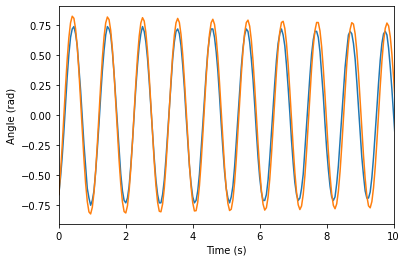

In [17]:
#manual fit of air
omega0 = sqrt(g/l)
eta = 1e-5
rho = rho_air
manual_air = solve_ivp(fluid, t_air, IC_air, t_eval=df_air['Time (s)'])

#air data plotted against manual fit
fig, ax = plt.subplots()

ax.plot(df_air['Time (s)'], df_air['Angle (rad)'])
ax.plot(manual_air.t, manual_air.y[0]);

ax.set_xlim(0,10)

ax.set_xlabel('Time (s)');
ax.set_ylabel('Angle (rad)');

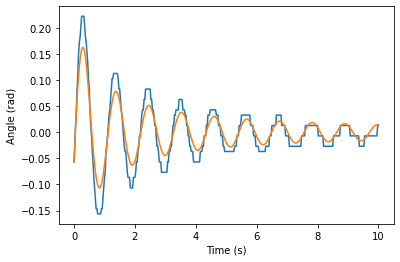

In [18]:
#manual fit of water
omega0 = .935*sqrt(g/l)
eta = 1e-3
rho = rho_water
manual_water = solve_ivp(fluid, t_water, IC_water, t_eval=df_water['Time (s)'])

#water data plotted against manual fit
fig, ax = plt.subplots()

ax.plot(df_water['Time (s)'], df_water['Angle (rad)'])
ax.plot(manual_water.t, manual_water.y[0]);

ax.set_xlabel('Time (s)');
ax.set_ylabel('Angle (rad)');

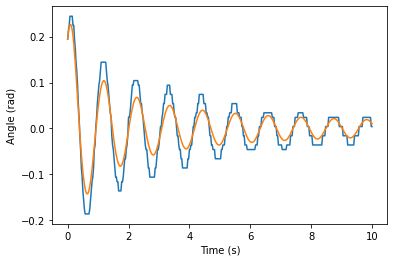

In [19]:
#manual fit of alcohol
omega0 = .93*sqrt(g/l)
eta = 1e-3
rho = rho_alc
manual_alc = solve_ivp(fluid, t_alc, IC_alc, t_eval=df_alc['Time (s)'])

#alcohol data plotted against manual fit
fig, ax = plt.subplots()

ax.plot(df_alc['Time (s)'], df_alc['Angle (rad)'])
ax.plot(manual_alc.t, manual_alc.y[0]);

ax.set_xlabel('Time (s)');
ax.set_ylabel('Angle (rad)');

##sphere - approximation
$d = 2r$, and $S = \pi r^2 = \pi d^2/4$, $a = 6\pi r$


In [20]:
def SSD_water(param):
  global eta, omega0
  eta = param[0]
  omega0 = param[1]
  w0 = [param[2], param[3]]
  if (eta < 0):
    return 1e12
  else:
    sol = solve_ivp(fluid, t_water, w0, t_eval=df_water['Time (s)'])
    dif = df_water['Angle (rad)'] - sol.y[0]
    return np.dot(dif, dif)

def SSD_alc(param):
  global eta, omega0
  eta = param[0]
  omega0 = param[1]
  w0 = [param[2], param[3]]
  if (eta < 0):
    return 1e12
  else:
    sol = solve_ivp(fluid, t_alc, w0, t_eval=df_alc['Time (s)'])
    dif = df_alc['Angle (rad)'] - sol.y[0]
    return np.dot(dif, dif)

In [31]:
param_water = [1e-3, .935*sqrt(g/l), df_water['Angle (rad)'][0], df_water['Velocity (rad/s)'][0]]
res_water = minimize(SSD_water, param_water, method = 'Nelder-Mead', tol = 1e-2, options = {'disp': True})

Optimization terminated successfully.
         Current function value: 0.050458
         Iterations: 75
         Function evaluations: 131


In [42]:
print(f"eta = {res_water.x[0]: .6f}")
print(f"omega0 = {res_water.x[1]: .3f}")
print(f"initial theta = {res_water.x[2]: .3f}")
print(f"initial omega = {res_water.x[3]: .3f}")

eta =  0.000002
omega0 =  5.875
initial theta = -0.061
initial omega =  2.034


In [33]:
eta = res_water.x[0]
omega0 = res_water.x[1]
w0 = [res_water.x[2], res_water.x[3]]
sol_best_water = solve_ivp(fluid, t_water, w0, t_eval=df_water['Time (s)'])

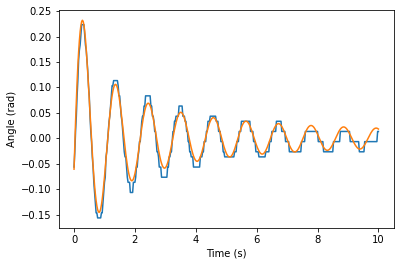

In [34]:
fig1, ax1 = plt.subplots()

ax1.plot(df_water['Time (s)'], df_water['Angle (rad)'], label='Data')
ax1.plot(sol_best_water.t, sol_best_water.y[0], label='Numerical Fit')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (rad)');

In [43]:
param_alc = [1e-3, .93*sqrt(g/l), df_alc['Angle (rad)'][0], df_alc['Velocity (rad/s)'][0]]
res_alc = minimize(SSD_alc, param_alc, method = 'Nelder-Mead', tol = 1e-3, options = {'disp': True})

Optimization terminated successfully.
         Current function value: 0.190357
         Iterations: 127
         Function evaluations: 219


In [44]:
print(f"eta = {res_alc.x[0]: .3f}")
print(f"omega0 = {res_alc.x[1]: .3f}")
print(f"initial theta = {res_alc.x[2]: .3f}")
print(f"initial omega = {res_alc.x[3]: .3f}")

eta =  0.000
omega0 =  5.851
initial theta =  0.255
initial omega =  0.774


In [45]:
eta = res_alc.x[0]
omega0 = res_alc.x[1]
w0 = [res_alc.x[2], res_alc.x[3]]
sol_best_alc = solve_ivp(fluid, t_alc, w0, t_eval=df_alc['Time (s)'])

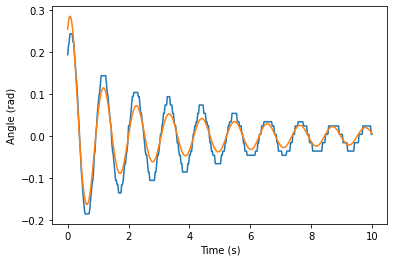

In [46]:
fig1, ax1 = plt.subplots()

ax1.plot(df_alc['Time (s)'], df_alc['Angle (rad)'], label='Data')
ax1.plot(sol_best_alc.t, sol_best_alc.y[0], label='Numerical Fit')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (rad)');

# Analysis
viscosity is depended on temperature, so we need temperature of the room when taking experiment